# Кейс 1. РЖД - Анализ данных для формирования составов

## 1. Загрузка данных и проверка структуры

In [ ]:
# Импорт библиотек

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Загрузка данных из подготовленного ранее файла
# Исходные данные были сгруппированы по станциям и вагонам, последовательности операций записаны в одну строку

from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/RZD'

data = pd.read_csv(path + '/df_svod_all_st.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data.info() # проверка структуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980492 entries, 0 to 980491
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   станция                   980492 non-null  int64  
 1   вагон                     980492 non-null  int64  
 2   операция_первая           980492 non-null  int64  
 3   операция_последняя        980492 non-null  int64  
 4   все_операции              980492 non-null  object 
 5   количество_операций       980492 non-null  int64  
 6   время_первой_операции     980492 non-null  object 
 7   время_последней_операции  980492 non-null  object 
 8   разница_времени           980492 non-null  object 
 9   станция_назначения        980492 non-null  int64  
 10  опасный_груз              980492 non-null  float64
 11  код_груза                 980492 non-null  int64  
 12  род_вагона                840338 non-null  float64
 13  вес_тары_вагона           322778 non-null  f

# 2. Преобразование и создание признаков

In [ ]:
# Преобразования типов

data['время_первой_операции'] = pd.to_datetime(data['время_первой_операции'])
data['время_последней_операции'] = pd.to_datetime(data['время_последней_операции'])

# новый признак - длительность цепочки операций в часах
data['длительность'] = (data['время_последней_операции'] - data['время_первой_операции'])
data['длительность_час'] = data['длительность'].apply(lambda x: x.seconds/3600 + x.days*24) # переведём timedelta в часы

In [ ]:
# Какое количество вагов в месяц обслуживает через станцию
st_kol_vag = data['станция'].value_counts().to_dict()
st_val = data['станция'].value_counts()
st_val.describe()

count      744.000000
mean      1317.865591
std       3575.956520
min          1.000000
25%         37.750000
50%        194.000000
75%       1006.250000
max      43702.000000
Name: станция, dtype: float64

In [ ]:
data['станция'].value_counts()

985906    43702
986103    36589
946801    31350
967600    27130
863007    26287
          ...  
949509        1
986001        1
975804        1
834606        1
881908        1
Name: станция, Length: 744, dtype: int64

Можно поделить станции на категории на основе **количества пропущенных через станцию вагонов** и создать соответствующий признак, отражающий "ранг станции"

In [ ]:
def rang_st(st):
    if st < 41:
        return 1
    elif st < 200:
        return 2
    elif st < 1000:
        return 3
    elif st < 5000:
        return 4
    elif st < 10000:
        return 5
    else:
        return 6

data['ст_опер_кол_ваг'] = data['станция'].apply(lambda st: st_kol_vag[st])
#data['ст_назн_кол_ваг'] = data['станция_назначения'].apply(lambda st: st_kol_vag[st]) # есть станции, которых нет в станции операции
data['ранг_станции'] = data['ст_опер_кол_ваг'].apply(lambda st: rang_st(st))

## 3. Работа с последовательностями операций

In [ ]:
data['все_операции'].value_counts() # все различные виды операций

[18]                                      90176
[3, 80, 21, 81, 4]                        59601
[18, 4]                                   54582
[3, 80, 10, 4]                            52417
[80, 10, 4]                               51167
                                          ...  
[3, 80, 10, 4, 3, 80, 4, 10, 4]               1
[20, 80, 10, 81]                              1
[3, 80, 78, 20, 10, 81, 4]                    1
[3, 80, 78, 20, 80, 20, 80, 10, 81, 4]        1
[3, 80, 21, 19, 81, 80, 11, 81, 4]            1
Name: все_операции, Length: 7647, dtype: int64

Для одного вагона встречаются **незавершённые технологические циклы**, и есть **ряды из нескольких циклов**. Для анализа нам необходимо взять только полные и завершённые, так как по их длительности можно будет выполнить прогноз


In [ ]:
# Выберем ситуации, когда первая и последняя операция - исключение и включение в поезд

data_34 = data[(data['операция_последняя'] == 4) & (data['операция_первая'] == 3)].copy() 
data_34.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 333673 entries, 3 to 980491
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   станция                   333673 non-null  int64          
 1   вагон                     333673 non-null  int64          
 2   операция_первая           333673 non-null  int64          
 3   операция_последняя        333673 non-null  int64          
 4   все_операции              333673 non-null  object         
 5   количество_операций       333673 non-null  int64          
 6   время_первой_операции     333673 non-null  datetime64[ns] 
 7   время_последней_операции  333673 non-null  datetime64[ns] 
 8   разница_времени           333673 non-null  object         
 9   станция_назначения        333673 non-null  int64          
 10  опасный_груз              333673 non-null  float64        
 11  код_груза                 333673 non-null  int64    

In [ ]:
data_34.head(10)

,станция,вагон,операция_первая,операция_последняя,все_операции,количество_операций,время_первой_операции,время_последней_операции,разница_времени,станция_назначения,опасный_груз,код_груза,род_вагона,вес_тары_вагона,изм_станции,длительность,длительность_час,ст_опер_кол_ваг,ранг_станции
3,830003,24579856,3,4,"[3, 80, 19, 81, 4, 3, 18, 4]",8,2020-07-26 18:38:00,2020-07-29 06:02:00,2 days 11:24:00,830003,0.0,0,20.0,NaN,0,2 days 11:24:00,59.400000,1155,4
4,830003,24622276,3,4,"[3, 80, 28, 19, 81, 4]",6,2020-07-15 23:32:00,2020-07-17 04:27:00,1 days 04:55:00,830003,0.0,0,20.0,NaN,0,1 days 04:55:00,28.916667,1155,4
5,830003,28034288,3,4,"[3, 80, 28, 19, 81, 4]",6,2020-07-25 00:21:00,2020-07-28 05:40:00,3 days 05:19:00,830003,0.0,0,20.0,NaN,0,3 days 05:19:00,77.316667,1155,4
7,830003,28035723,3,4,"[3, 81, 4]",3,2020-07-23 16:57:00,2020-07-25 08:47:00,1 days 15:50:00,830003,0.0,0,20.0,NaN,0,1 days 15:50:00,39.833333,1155,4
14,830003,29019288,3,4,"[3, 18, 4]",3,2020-07-24 20:51:00,2020-07-28 02:00:00,3 days 05:09:00,830003,0.0,0,20.0,NaN,0,3 days 05:09:00,77.150000,1155,4
18,830003,29038684,3,4,"[3, 80, 81, 4, 3, 4]",6,2020-07-19 22:50:00,2020-07-29 09:09:00,9 days 10:19:00,830003,0.0,0,20.0,NaN,0,9 days 10:19:00,226.316667,1155,4
30,830003,29104163,3,4,"[3, 18, 4]",3,2020-07-18 16:52:00,2020-07-25 11:48:00,6 days 18:56:00,830003,0.0,0,20.0,NaN,0,6 days 18:56:00,162.933333,1155,4
31,830003,29105855,3,4,"[3, 80, 21, 19, 81, 3, 80, 21, 19, 81, 4]",11,2020-07-17 15:35:00,2020-07-28 20:17:00,11 days 04:42:00,830003,0.0,0,20.0,NaN,0,11 days 04:42:00,268.700000,1155,4
33,830003,29106739,3,4,"[3, 80, 21, 19, 81, 4]",6,2020-07-16 09:15:00,2020-07-19 01:43:00,2 days 16:28:00,830003,0.0,0,20.0,NaN,0,2 days 16:28:00,64.466667,1155,4
34,830003,29108982,3,4,"[3, 18, 4]",3,2020-07-27 10:56:00,2020-07-31 23:00:00,4 days 12:04:00,830003,0.0,0,20.0,NaN,0,4 days 12:04:00,108.066667,1155,4


Text(0.5, 1.0, 'Распределение количества операций с вагонами')

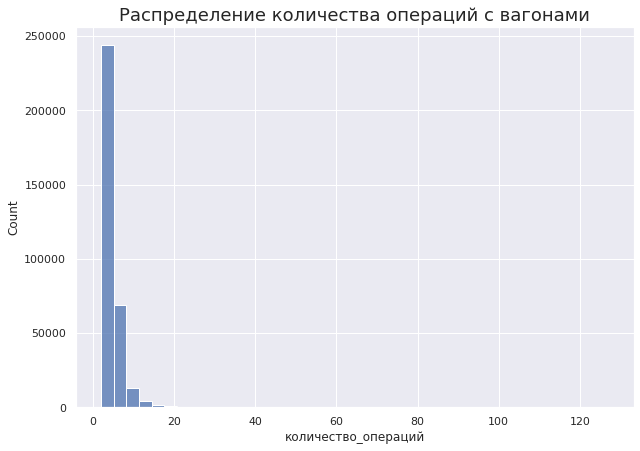

In [ ]:
# Распределение кол-ва операций

plt.rcParams['figure.figsize'] = (10, 7) # размер фигуры
sns.set_theme() # стандартный вид графика

fig = sns.histplot(data=data_34, x='количество_операций', bins=40) # гистограмма
fig.set_title('Распределение количества операций с вагонами', fontdict={'fontsize': 18})

Число технологических циклов **длиннее 20 операций очень мало**, отфильтруем такие записи и посмотрим подробнее на интервал 0-20 операций в цикле

Text(0.5, 1.0, 'Распределение количества операций с вагонами')

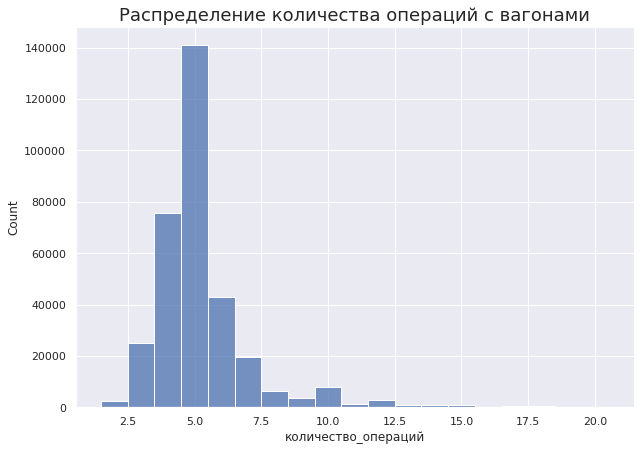

In [ ]:
# Распределение кол-ва операций в интервале от 0 до 20

fig = sns.histplot(data=data_34[data_34['количество_операций']<=20], x='количество_операций', discrete=True) # гистограмма
fig.set_title('Распределение количества операций с вагонами', fontdict={'fontsize': 18})

Среди циклов длиной **до 20 операций включительно** наиболее часто встречаются циклы длительностью **4-6 операций**

## 4. Работа с длительностью технологических циклов

Text(0.5, 1.0, 'Распределение длительности технологических циклов')

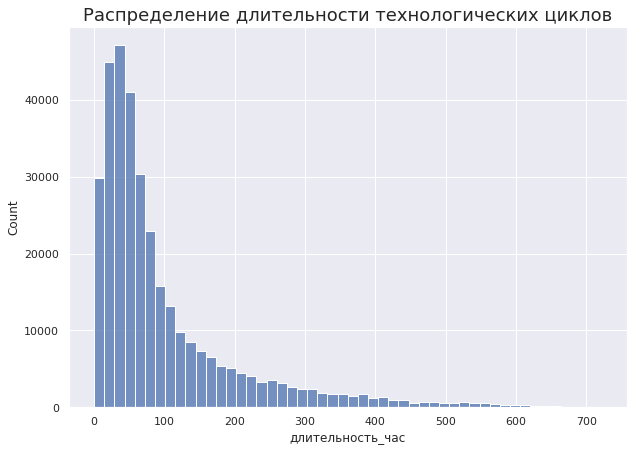

In [ ]:
# Распределение длительности технологических циклов

fig = sns.histplot(data=data_34, x='длительность_час', bins=50) # гистограмма
fig.set_title('Распределение длительности технологических циклов', fontdict={'fontsize': 18})

У нас в датасете остались п**оследовательности операций из нескольких циклов**, их длина видимо составляет несколько сотен часов


In [ ]:
# Найдём модальное значение длины технологического цикла в часах

data_34['длительность_час'].mode()[0]

44.93333333333334

Наиболее часто встречается ситуация, когда **технологический цикл укладывается в 45 часов**

**Разделим данные на 2 датасета** по длительности технологического цикла и посмотрим на распределение категориальных переменных

In [ ]:
# Разобъем data_34 на два по длительности цикла - до 36 и более 36часов
data_34_smoll = data_34[data_34['длительность_час']<=36]
data_34_big = data_34[data_34['длительность_час']>36]

## 5. Анализ признаков для циклов менее 36 часов и свыше 36 часов, выявление зависимостей

In [ ]:
# Опасного груза нет
data_34['опасный_груз'].value_counts()

0.0    333673
Name: опасный_груз, dtype: int64

In [ ]:
# Код груза не указан
data_34['код_груза'].value_counts()

0    333673
Name: код_груза, dtype: int64

In [ ]:
# Род вагона
data_34['род_вагона'].value_counts()

60.0    215134
70.0     39680
96.0     31162
90.0     17109
40.0     14902
20.0     10253
93.0      2053
95.0      1959
87.0       899
92.0       517
99.0         5
Name: род_вагона, dtype: int64

In [ ]:
data_34_smoll['род_вагона'].value_counts() 

60.0    72697
96.0     8474
70.0     7701
90.0     4700
40.0     4666
20.0      532
95.0      101
93.0       53
87.0       28
92.0       13
Name: род_вагона, dtype: int64

In [ ]:
data_34_big['род_вагона'].value_counts()# распределение рода вагонов примерно одинаковое в двух выборках

60.0    142437
70.0     31979
96.0     22688
90.0     12409
40.0     10236
20.0      9721
93.0      2000
95.0      1858
87.0       871
92.0       504
99.0         5
Name: род_вагона, dtype: int64

In [ ]:
# Будет ли изменяться станция
data_34['изм_станции'].value_counts()

0    246120
1     87553
Name: изм_станции, dtype: int64

In [ ]:
data_34_smoll['изм_станции'].value_counts(normalize=True) 

0    0.517365
1    0.482635
Name: изм_станции, dtype: float64

In [ ]:
data_34_big['изм_станции'].value_counts(normalize=True)

0    0.830474
1    0.169526
Name: изм_станции, dtype: float64

Text(0.5, 1.0, 'Изменение станции - циклы свыше 36 часов')

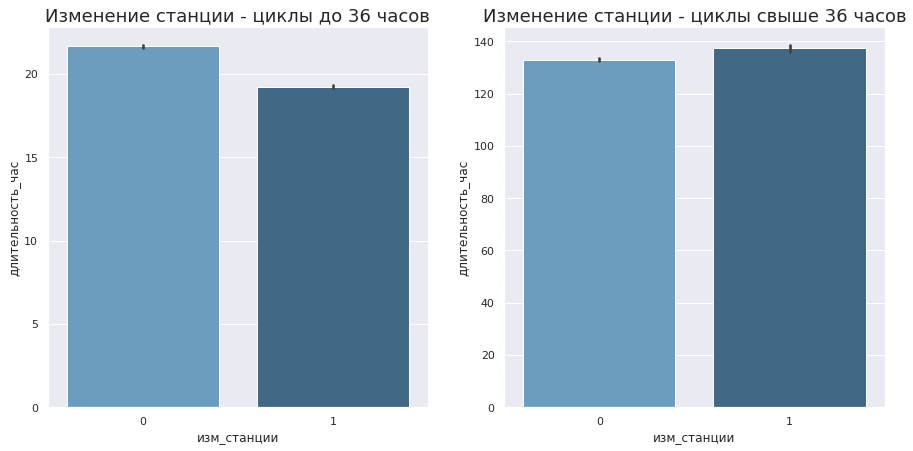

In [ ]:
# График - признак изменения станции для циклов более и менее 36 часов

fig1, (ax1) = plt.subplots(ncols=2, figsize=(15, 7))

sns.barplot(data=data_34_smoll, x='изм_станции', y='длительность_час', ax=ax1[0], palette="Blues_d")
ax1[0].set_title('Изменение станции - циклы до 36 часов', fontdict={'fontsize': 18})

sns.barplot(data=data_34_big, x='изм_станции', y='длительность_час', ax=ax1[1], palette="Blues_d")
ax1[1].set_title('Изменение станции - циклы свыше 36 часов', fontdict={'fontsize': 18})


Text(0.5, 1.0, 'Род вагона - циклы свыше 36 часов')

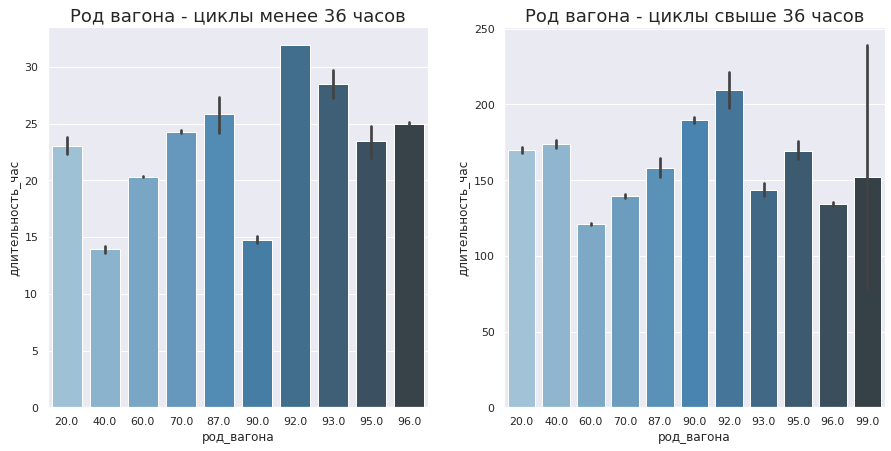

In [ ]:
# График - род вагона для циклов более и менее 36 часов

fig1, (ax1) = plt.subplots(ncols=2, figsize=(15, 7))

sns.barplot(data=data_34_smoll, x='род_вагона', y='длительность_час', ax=ax1[0], palette="Blues_d")
ax1[0].set_title('Род вагона - циклы менее 36 часов', fontdict={'fontsize': 18})

sns.barplot(data=data_34_big, x='род_вагона', y='длительность_час', ax=ax1[1], palette="Blues_d")
ax1[1].set_title('Род вагона - циклы свыше 36 часов', fontdict={'fontsize': 18})

**Если вагон транзитный, то его стараются быстрее включить в поезд.** В половине случаев успевают за 36 часов. Если станция разгрузки является конечной, то длительность цикла до следующего включения в поезд выше 36 часов.

In [ ]:
# Количество операций за цикл
data_34['количество_операций'].value_counts()

5      141093
4       75746
6       42774
3       24880
7       19493
        ...  
127         1
93          1
82          1
84          1
106         1
Name: количество_операций, Length: 94, dtype: int64

In [ ]:
data_34_smoll['количество_операций'].value_counts(normalize=True) 

5     0.551518
4     0.198242
3     0.104118
6     0.078917
7     0.055959
2     0.006831
8     0.002607
9     0.001667
12    0.000081
10    0.000040
11    0.000020
Name: количество_операций, dtype: float64

In [ ]:
data_34_big['количество_операций'].value_counts(normalize=True) 

5      0.368594
4      0.239135
6      0.148968
3      0.062103
7      0.059457
         ...   
127    0.000004
93     0.000004
82     0.000004
84     0.000004
106    0.000004
Name: количество_операций, Length: 94, dtype: float64

У транзитных вагонов цикл не превышает 12 операций, в половине случаев это 5 операций, т.ч. включение и изключения из поезда. Таким образом промежуточных операций 3.  
Тогда как в более длительном периоде - количество операций выше.

Text(0.5, 1.0, 'Распределение количества операций с вагонами (<36 H)')

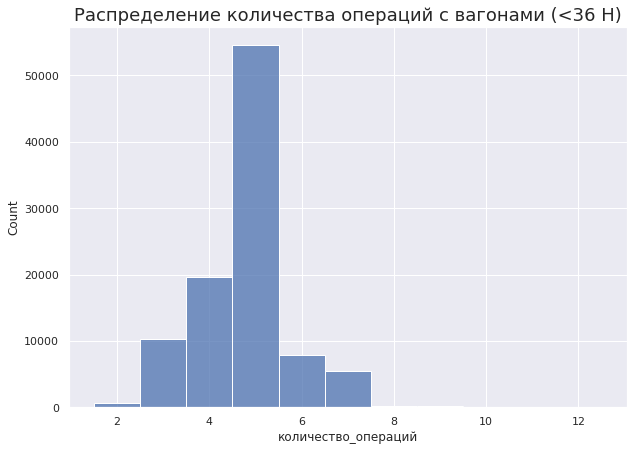

In [ ]:
# Распределение кол-ва операций для циклов менее 36 часов
plt.rcParams['figure.figsize'] = (10, 7) # размер фигуры

fig = sns.histplot(data=data_34_smoll, x='количество_операций', discrete=True) # гистограмма
fig.set_title('Распределение количества операций с вагонами (<36 H)', fontdict={'fontsize': 18})

In [ ]:
# Ранг станции оперции
data_34['ранг_станции'].value_counts()

6    134896
4    108429
5     46283
3     34877
2      8197
1       991
Name: ранг_станции, dtype: int64

In [ ]:
data_34_smoll['ранг_станции'].value_counts(normalize=True)

6    0.580710
4    0.205588
5    0.123134
3    0.065164
2    0.022018
1    0.003385
Name: ранг_станции, dtype: float64

In [ ]:
data_34_big['ранг_станции'].value_counts(normalize=True)

4    0.375288
6    0.329882
5    0.145274
3    0.121121
2    0.025640
1    0.002795
Name: ранг_станции, dtype: float64

Чем крупнее станция, тем быстрее она старается вернуть вагон обратно в поезд. В 60% это самые крупные станции.   
В более длительном цикле самые крупные странции составляют только 33%. Чаще задержка на средних станций.


Text(0.5, 1.0, 'Ранг станции - циклы свыше 36 часов')

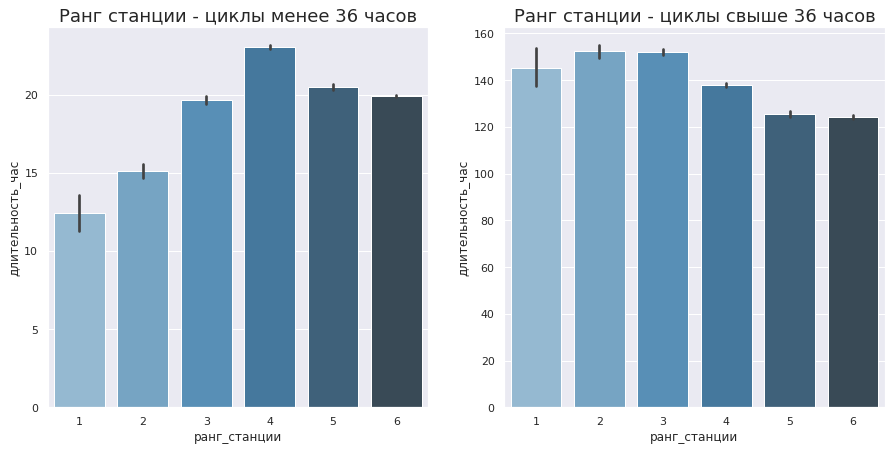

In [ ]:
# Ранги станций 
fig1, (ax1) = plt.subplots(ncols=2, figsize=(15, 7))

sns.barplot(data=data_34_smoll, x='ранг_станции', y='длительность_час', ax=ax1[0], palette="Blues_d")
ax1[0].set_title('Ранг станции - циклы менее 36 часов', fontdict={'fontsize': 18})

sns.barplot(data=data_34_big, x='ранг_станции', y='длительность_час', ax=ax1[1], palette="Blues_d")
ax1[1].set_title('Ранг станции - циклы свыше 36 часов', fontdict={'fontsize': 18})

In [ ]:
# Ранг станции оперции
data_34.columns

Index(['станция', 'вагон', 'операция_первая', 'операция_последняя',
       'все_операции', 'количество_операций', 'время_первой_операции',
       'время_последней_операции', 'разница_времени', 'станция_назначения',
       'опасный_груз', 'код_груза', 'род_вагона', 'вес_тары_вагона',
       'изм_станции', 'длительность', 'длительность_час', 'ст_опер_кол_ваг',
       'ранг_станции'],
      dtype='object')

In [ ]:
data_34.to_csv(path+'/data_34')

Text(0.5, 1.0, 'Длительность технологического цикла в часах')

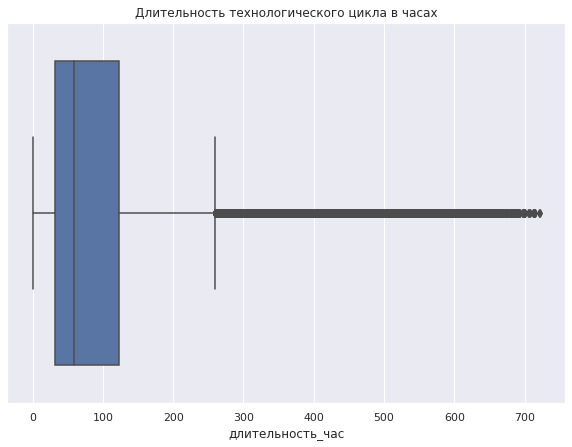

In [ ]:
# Оценим, есть ли выбросы для признака Длительность операций

fig = sns.boxplot(data=data_34, x='длительность_час')
fig.set_title('Длительность технологического цикла в часах')

Все значения **свыше 250** (примерно) определяются как **выбросы**, попробуем их удалить

In [ ]:
# Удаление выбросов
data_34 = data_34[data_34['длительность_час'] < 250]

In [ ]:
# Посмотрим, что за операции с длительностью в часах = 1-2 час

data_34[data_34['длительность_час'] <=2]['все_операции'].value_counts()

[3, 18, 4]                1698
[3, 28, 18, 4]             268
[3, 80, 28, 18, 4]          76
[3, 78, 20, 18, 4]          61
[3, 78, 28, 18, 79, 4]      52
[3, 78, 20, 4]              40
[3, 80, 21, 4]              38
[3, 80, 28, 4]              18
[3, 80, 21, 19, 81, 4]       9
[3, 78, 28, 18, 4]           9
[3, 80, 81, 4]               8
[3, 78, 28, 4]               6
[3, 4]                       4
[3, 80, 28, 19, 81, 4]       3
[3, 80, 18, 4]               3
[3, 80, 11, 81, 4]           2
[3, 78, 10, 79, 4]           1
[3, 28, 4]                   1
[3, 80, 19, 81, 4]           1
[3, 78, 18, 4]               1
[3, 80, 28, 80, 18, 4]       1
[3, 80, 10, 4]               1
[3, 80, 21, 81, 4]           1
Name: все_операции, dtype: int64

Text(0.5, 1.0, 'Зависимость длительности цикла в часах от кол-ва операций')

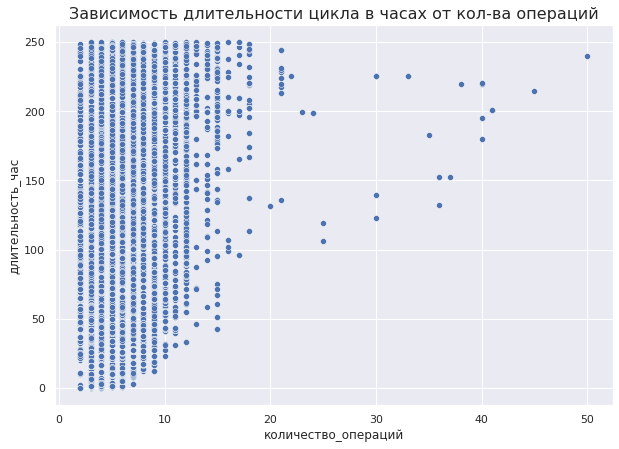

In [ ]:
# Посмотрим, есть ли зависимость длительности цикла от кол-ва операций в нём

fig = sns.scatterplot(data=data_34, x='количество_операций', y='длительность_час')
fig.set_title('Зависимость длительности цикла в часах от кол-ва операций', fontdict={'fontsize': 16})


Любому значению переменной Х соответствует любое значение переменной Y, не удаётся установить зависимость



Text(0.5, 1.0, 'Среднее значение длительности цикла в зависимости от кол-ва операций')

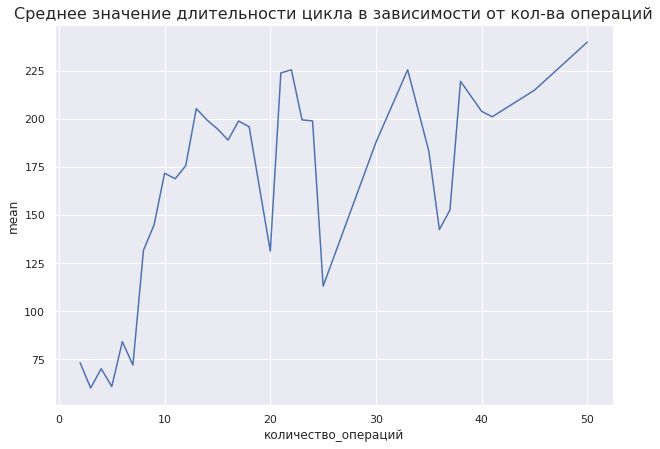

In [ ]:
# Среднее и значение длительности в часах

aggfuncs = ['count', 'mean']
grouped = data_34.groupby('количество_операций', as_index=False)['длительность_час'].agg(aggfuncs)

# График зависимости
fig = sns.lineplot(data=grouped, x='количество_операций', y='mean')
fig.set_title('Среднее значение длительности цикла в зависимости от кол-ва операций', fontdict={'fontsize': 16})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Среднее значение длительности цикла в зависимости от начала цикла')

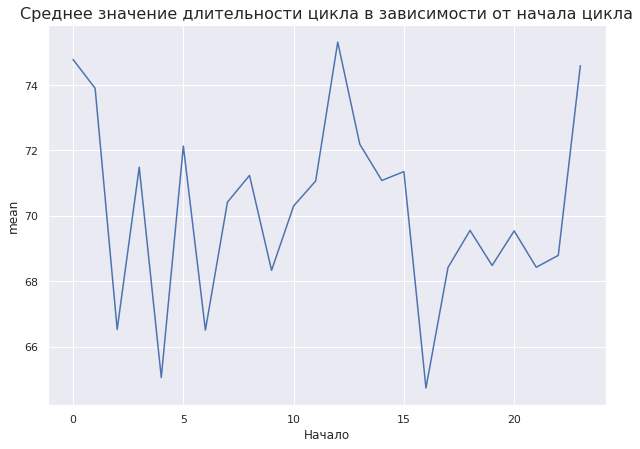

In [ ]:
# Оценим, есть ли зависимость от времени начала операции - ночь или день

# Создадим признак, выделим час из времени начала операции
data_34['Начало'] = data_34['время_первой_операции'].apply(lambda x: x.hour)

# Сгруппируем и выведем среднее значение, так как диаграмма рассеяния ничего не показывает
aggfuncs = ['count', 'mean']
grouped = data_34.groupby('Начало', as_index=False)['длительность_час'].agg(aggfuncs)

# График зависимости
fig = sns.lineplot(data=grouped, x='Начало', y='mean')
fig.set_title('Среднее значение длительности цикла в зависимости от начала цикла', fontdict={'fontsize': 16})

Не похоже, что этот график иллюстрирует какую-то зависимость

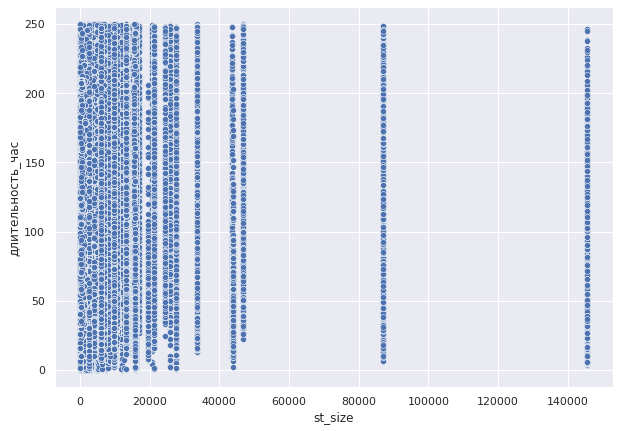

In [ ]:
# Зависимость от размера станции

# Сгруппируем кол-во операций по станциям, получим "размер станции"
data_st_size = data_34.groupby('станция', as_index=False).agg(st_size=('количество_операций', 'sum'))

# Объединим исходный файл с данной таблицей
data_34 = pd.merge(data_34, data_st_size, how='left', on='станция')

# Покажем зависимость длительности операций от размера станций
fig = sns.scatterplot(data=data_34, x='st_size', y='длительность_час')

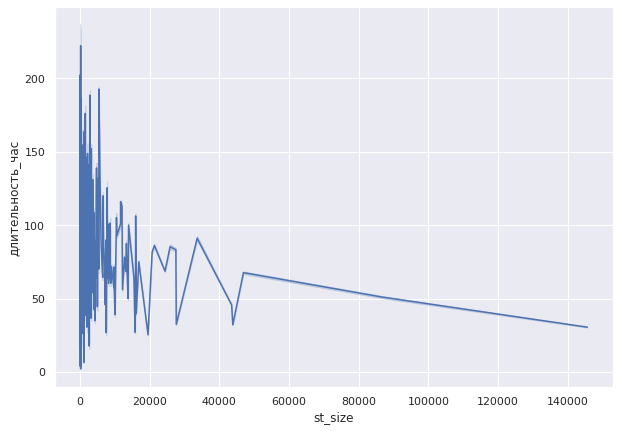

In [ ]:
# Покажем зависимость длительности операций от размера станций
fig = sns.lineplot(data=data_34, x='st_size', y='длительность_час')


Большой разброс длительности цикла для станций небольшого размера. Это может быть связано с тем, что таких станций больше

Text(0.5, 1.0, 'Корреляция между признаками датасета')

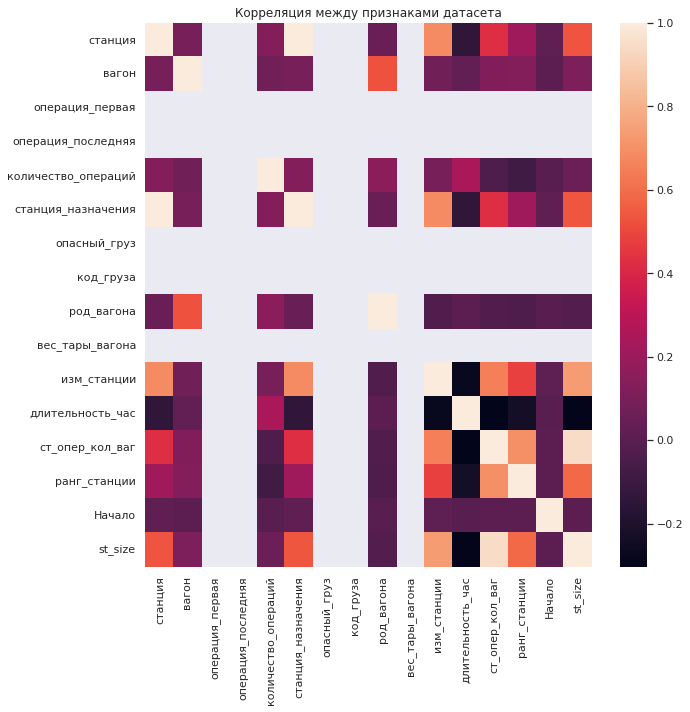

In [ ]:
# Корреляция между признаками

plt.rcParams['figure.figsize'] = (10, 10) # размер фигуры

fig = sns.heatmap(data_34.corr())
fig.set_title('Корреляция между признаками датасета')